In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from variational_forms import _VariationalForm
from feature_maps import MediumFeatureMap
from pegasos_experiment import generate_qsvm_data, run_advanced_experiment
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.kernels import QuantumKernel
from quantum_neural_networks import QuantumNeuralNetwork
from qiskit import BasicAer

In [2]:
# blue
color_0 = '#1f77b4'
color_0_light = '#8fbbd9'

# orange
color_1 = '#ff7f0e'
color_1_light = '#ffbf86'

colors = [color_0, color_1]
colors_light = [color_0_light,color_1_light]

# other constants
lower_percentile = 0.159
upper_percentile = 0.841

plt.rcParams.update({'font.size': 24,
                     'xtick.labelsize': 20,
                     'ytick.labelsize': 20,
                     'axes.titlesize': 28,
                     'axes.labelsize': 28,
                     'mathtext.fontset': 'stix',
                     'font.family': 'STIXGeneral'})

In [3]:
margin = 0.1
positive = 'positive' if margin > 0 else 'negative'
filename = f'data/advanced_margin_{margin}_data.csv'
# data size
M = 100
# iterations
N = 1000
# number of repeats per experiment
n = 50
shots = [8,16,32,64,128,256,512,1024,2048,4096]
Cs = [10.,1000.]

In [30]:


for C in Cs:
    run_advanced_experiment(margin,C,N,shots,M,0,n)
        

100%|██████████| 50/50 [01:46<00:00,  2.14s/it]


In [5]:
# load data
data = pd.read_csv(filename)
data = data[data['R'] > 4]

epsilons1 = []
epsilons2 = []
stops = []


for j, r in data.iterrows():
    file = f"data/dumps/{int(r['seed'])}_R_{int(r['R'])}_C_{r['C']}_M_{int(r['M'])}_margin_{margin}.pkl"
    history = pickle.load(open(file,'rb')) 
    hinges = np.mean(history['hinge_loss'],axis=-1)
    
    eps1 = history['epsilons']
    eps2 = history['epsilons2']


    #eps = np.array([np.max(np.abs(np.sum(y*(a[i] - a_state[-1])*K,axis=1))) for i in range(len(a_state))])

    diff = np.abs(hinges[1:] - hinges[:-1])
    try:
        stop = np.where(diff < 1e-3)[0][0]
        stops.append(stop)
    except:
        print(r['R'], 'did not converge')
        stops.append(np.nan)
    epsilons1.append(eps1)
    epsilons2.append(eps2)

stops = np.array(stops)
epsilons1 = np.array(epsilons1)
epsilons2 = np.array(epsilons2)

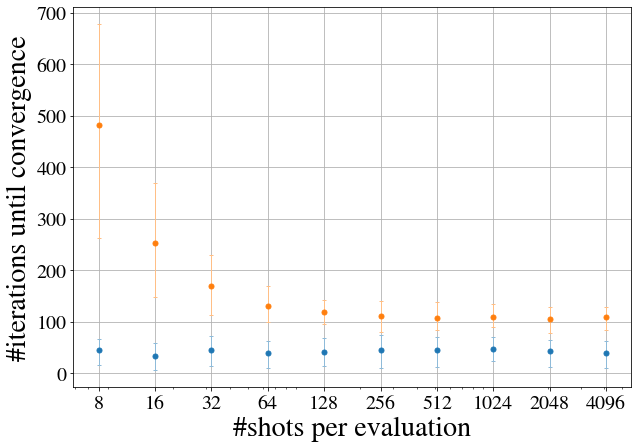

In [6]:
def plot_conv(C,c,cl):
    stops_R = [stops[np.invert(np.isnan(stops)) & (data['R'] == R) & (data['C'] == C)] for R in shots]
    stop_means = np.array([np.mean(stops_R[i]) for i in range(len(stops_R))])
    upper = np.array([np.quantile(stops_R[i], upper_percentile) for i in range(len(stops_R))])
    lower = np.array([np.quantile(stops_R[i],lower_percentile) for i in range(len(stops_R))])
    errors = np.array([stop_means - lower, upper - stop_means])
    #stop_std = np.std(stops_R,axis=1)
    plt.errorbar(shots,stop_means,yerr=errors,label=r'$\lambda = 1/{{%s}}$'%int(C),marker='.',ecolor=cl,elinewidth=1.,ls='',capsize=2,
        color=c, ms=10)

plt.figure(figsize=(10,7))

for i, C in enumerate(Cs):
    plot_conv(C,colors[i],colors_light[i])
plt.xscale('log')
plt.xticks(shots,shots)
plt.xlabel('#shots per evaluation')
plt.ylabel('#iterations until convergence')
if margin < 0:
    plt.legend()
plt.grid()
plt.savefig(f'plots/convergence_{positive}_margin.png',dpi=300,bbox_inches='tight')


[-7.36979215  2.57149381]
[-9.52229877 30.94444861]


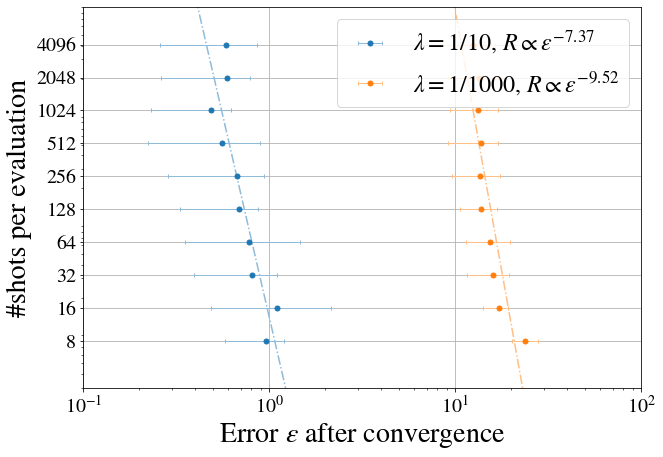

In [32]:
def plot_epsilon_convergence(C,c,cl):
    epsilons_conv = np.zeros(len(epsilons2))
    for i in range(len(epsilons1)):
        try:
            epsilons_conv[i] = epsilons2[i,int(stops[i])]
        except:
            epsilons_conv[i] = np.nan

    filter = (data['C'] == C) & np.invert(np.isnan(epsilons_conv))
    epsC = np.array([epsilons_conv[filter & (data['R'] == R)] for R in shots])
    eps_means = np.array([np.mean(epsC[i]) for i in range(len(shots))])
    upper = np.array([np.quantile(epsC[i], upper_percentile) for i in range(len(shots))])
    lower = np.array([np.quantile(epsC[i], lower_percentile) for i in range(len(shots))])
    errors = np.array([eps_means - lower, upper - eps_means])
    #eps_std = np.std(epsC,axis=1)
    p = np.polyfit(np.log(eps_means),np.log(shots),1)
    print(p)
    plt.errorbar(eps_means,shots,xerr=errors,label=r'$\lambda=1/{{%s}},\, R\propto\varepsilon^{{%.2f}}$'%(int(C),p[0]),
        marker='.',ecolor=cl,elinewidth=1.,ls='',capsize=2, color=c, ms=10)
    efine = np.geomspace(0.01,100)
    plt.plot(efine,np.exp(p[1])*efine**p[0],'-.',color=cl)


plt.figure(figsize=(10,7))
for i, C in enumerate(Cs):
    plot_epsilon_convergence(C,colors[i],colors_light[i])
plt.xscale('log')
plt.yscale('log')
plt.yticks(shots,shots)
plt.ylabel('#shots per evaluation')
plt.xlabel(r'Error $\varepsilon$ after convergence')

plt.legend(loc='upper right')
plt.ylim(3,9000)
plt.xlim(0.1,100)
plt.grid()
plt.savefig(f'plots/exponent_{positive}_margin_convergence.png',dpi=300,bbox_inches='tight')
